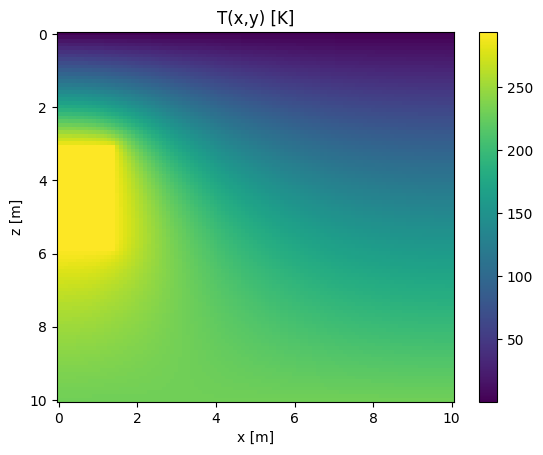

In [51]:
import numpy as np
import matplotlib.pyplot as plt


def methode_matrice_2D(C_p, K, rho, tau, Q_0, T_s, d_pS, p, l_x, l_z, Lx, Lz, temps, d):

     Nx=int(np.rint(Lx/d+1)) # Nombre de nœuds le long de X
     Nz=int(np.rint(Lz/d+1)) # Nombre de nœuds le long de Z
     A=np.zeros((Nx*Nz,Nx*Nz),dtype=np.double)
     b=np.zeros((Nx*Nz,1),dtype=np.double)

     
     sigma = 5.67e-8 # (W/(m^2K^4)) Constante de Stefan-Boltzmann
     def Aindex(i,j): #Associé la case i,j à sa colone dans la matrice M
          index=(j-1)*Nz+i
          return index-1
     
     def St(Q_0, d_pS, tau, temps):
        S = Q_0*(1+np.cos(temps*2*np.pi/tau))
        return S

     for i in np.arange(1,Nz+1,1): #i=1,..,Ny - numérotation des nœuds sur un maillage physique
        z=np.round((i-1)*d, decimals=12)
        for j in np.arange(1,Nx+1,1): #j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x=np.round((j-1)*d, decimals=12)


            # Condition frontière en z==0
            if i == 1:
              A[Aindex(i,j),Aindex(i,j)] = -(3+2*d/K*T_s**3)
              A[Aindex(i,j),Aindex(i+1,j)] = 4
              A[Aindex(i,j),Aindex(i+2,j)] = -1
              b[Aindex(i,j)] = -(2*d)*St(Q_0, d_pS, tau, temps)/(K)

            # Condition frontière en z==Lz
            elif i == Nz:
              A[Aindex(i,j), Aindex(i,j)] = 1    
              b[Aindex(i,j)] = T_s


            # Condition frontière en x==0 (T'(0) = 0)
            elif j == 1 :
              A[Aindex(i,j),Aindex(i,j)] = -3
              A[Aindex(i,j),Aindex(i,j+1)] = 4
              A[Aindex(i,j),Aindex(i,j+2)] = -1

            # Condition frontière en x==Lx (T'(Lx) = 0)
            elif j == Nx:
              A[Aindex(i,j),Aindex(i,j)] = 3
              A[Aindex(i,j),Aindex(i,j-1)] = -4
              A[Aindex(i,j),Aindex(i,j-2)] = 1              

            # Temperature à 394 K pour tous les points dans l'abris
            elif i > p/d+1  and i < (l_z+p)/d+1 and j < l_x/(2*d)+1:
              A[Aindex(i,j), Aindex(i,j)] = 1
              b[Aindex(i,j)] = 294 

            # Tous les autres points
            elif j > 1 and j < Nx and i > 1 and i < Nz  : 
              A[Aindex(i,j),Aindex(i,j-1)] = 1
              A[Aindex(i,j),Aindex(i,j+1)] = 1
              A[Aindex(i,j),Aindex(i,j)] = -4
              A[Aindex(i,j),Aindex(i-1,j)] = 1
              A[Aindex(i,j),Aindex(i+1,j)] = 1
            else :
               print('indice ne rentre dans aucune catégorie')
     
     
     return A, b, Nx, Nz

C_p = 675
K=1
rho=2000
tau=12
Q_0=492
T_s=230
d_pS=1
p=3
l_x=3
l_z=3
Lx=10
Lz=10
temps=6
d=0.1
A, b, Nx, Nz = methode_matrice_2D(C_p=C_p, K=K, rho=rho, tau=tau, Q_0=Q_0, T_s=T_s, d_pS=d_pS, p=p, l_x=l_x, l_z=l_z, Lx=Lx, Lz=Lz, temps = temps, d =d)

T=np.zeros((Nx*Nz,1),dtype=np.double)
Tr=np.zeros((Nz,Nx),dtype=np.double)

# x = np.linspace(-Lx, Lx, 2*Nx-1)  # Define x from -Lx to Lx

z = np.linspace(0, Lz, Nz)
x= np.linspace(0, Lx, Nx)
T = np.linalg.solve(A, b)
Tr=np.reshape(T,(Nz,Nx),order='F')

plt.figure(3)
plt.pcolor(x,z,Tr)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('T(x,y) [K]')
plt.xlabel('x [m]')    
plt.ylabel('z [m]')
plt.gca().invert_yaxis()
plt.show()



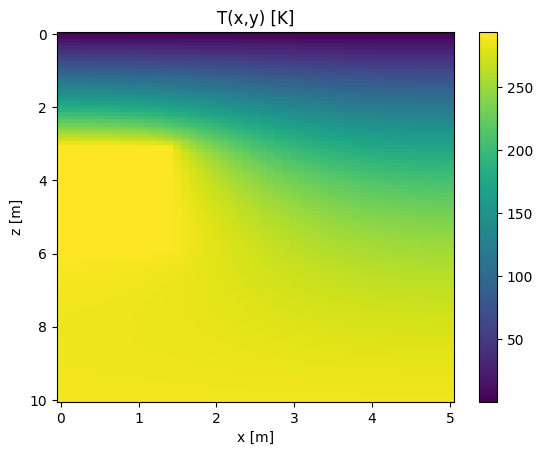

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def methode_matrice_2D_sparse(C_p, K, rho, tau, Q_0, T_s, d_pS, p, l_x, l_z, Lx, Lz, temps, d):
    Nx = int(np.rint(Lx / d + 1))  # Nombre de nœuds le long de X
    Nz = int(np.rint(Lz / d + 1))  # Nombre de nœuds le long de Z

    A = lil_matrix((Nx * Nz, Nx * Nz), dtype=np.double)
    b = np.zeros((Nx * Nz, 1), dtype=np.double)

    sigma = 5.67e-8  # (W/(m^2K^4)) Constante de Stefan-Boltzmann

    def Aindex(i, j):
        return (j - 1) * Nz + i - 1

    def St(Q_0, d_pS, tau, temps):
        return Q_0 * (1 + np.cos(temps * 2 * np.pi / tau))

    for i in range(1, Nz + 1):
        z = (i - 1) * d
        for j in range(1, Nx + 1):
            x = (j - 1) * d

            if j == 1:
                A[Aindex(i, j), Aindex(i, j)] = -3
                A[Aindex(i, j), Aindex(i, j + 1)] = 4
                A[Aindex(i, j), Aindex(i, j + 2)] = -1

            elif j == Nx:
                A[Aindex(i, j), Aindex(i, j)] = 3
                A[Aindex(i, j), Aindex(i, j - 1)] = -4
                A[Aindex(i, j), Aindex(i, j - 2)] = 1

            elif i == 1:
                A[Aindex(i, j), Aindex(i, j)] = -(3 + 2 * d / K * T_s ** 3)
                A[Aindex(i, j), Aindex(i + 1, j)] = 4
                A[Aindex(i, j), Aindex(i + 2, j)] = -1
                b[Aindex(i, j)] = -(2 * d) * St(Q_0, d_pS, tau, temps) / (K)

            elif i == Nz:
                A[Aindex(i, j), Aindex(i, j)] = 1
                b[Aindex(i, j)] = T_s

            elif i > p / d + 1 and i < (l_z + p) / d + 1 and j < l_x / (2 * d) + 1:
                A[Aindex(i, j), Aindex(i, j)] = 1
                b[Aindex(i, j)] = 294

            elif 1 < j < Nx and 1 < i < Nz:
                A[Aindex(i, j), Aindex(i, j - 1)] = 1
                A[Aindex(i, j), Aindex(i, j + 1)] = 1
                A[Aindex(i, j), Aindex(i, j)] = -4
                A[Aindex(i, j), Aindex(i - 1, j)] = 1
                A[Aindex(i, j), Aindex(i + 1, j)] = 1

    return A, b, Nx, Nz

C_p = 675
K = 1
rho = 2000
tau = 12
Q_0 = 492
T_s = 288.15
d_pS = 1
p = 3
l_x = 3
l_z = 3
Lx = 5
Lz = 10
temps = 6
d = 0.1
A, b, Nx, Nz = methode_matrice_2D_sparse(C_p=C_p, K=K, rho=rho, tau=tau, Q_0=Q_0, T_s=T_s, d_pS=d_pS, p=p, l_x=l_x,
                                         l_z=l_z, Lx=Lx, Lz=Lz, temps=temps, d=d)

T = spsolve(A.tocsr(), b)
Tr = np.reshape(T, (Nz, Nx), order='F')

x = np.linspace(0, Lx, Nx)
z = np.linspace(0, Lz, Nz)

plt.figure(3)
plt.pcolor(x, z, Tr)
plt.colorbar()
plt.title('T(x,y) [K]')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.gca().invert_yaxis()
plt.show()
